# 2nd. Try
In this algorithm the propose is to separate the scenarios into regions according to the collor distribution (clustering), separating the regions of ground, vegetation, sky and woods, then, for each of these clusters limiarize into shadowed and non-shadowed regions and finally remove them by enhancing the darker regions accordingly the lighter region's collor distribution.

In [1]:
import numpy as np
import imageio
import matplotlib as mpl
import matplotlib.pyplot as plt

In [13]:
img = imageio.imread("../images/shadow1.jpg")
rimg = img[:,:,0]
gimg = img[:,:,1]
bimg = img[:,:,2]

luminance_dataset = 0.299*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]
luminance_centroids = np.array([[np.min(luminance_dataset)], [np.max(luminance_dataset)]])

In [14]:
# find the closest cluster to the example pixel
def closest_cluster(centroids, example):
    # calculate the euclidian distances of the example from all centroids
    distances = np.linalg.norm(np.subtract(centroids, example),axis=1)

    # return the cluster number in which there is the min distance value
    return (np.where(distances == np.min(distances))[0][0] + 1)

In [15]:
# after each iteration, the centroids coordinates are updated
def update_centroids(labeled_dataset, dataset, centroids):
    # for each centroid, compute the average values of all respective pixels attributes
    for c in range(centroids.shape[0]):
        # get all pixels that belongs to 'c' cluster
        cluster = dataset[np.where(labeled_dataset == c+1)]

        # compute the average of attributes values
        if(cluster.shape[0] != 0):
            centroids[c] = np.mean(cluster,axis=0)

    return centroids

Text(0.5, 1.0, 'clusters')

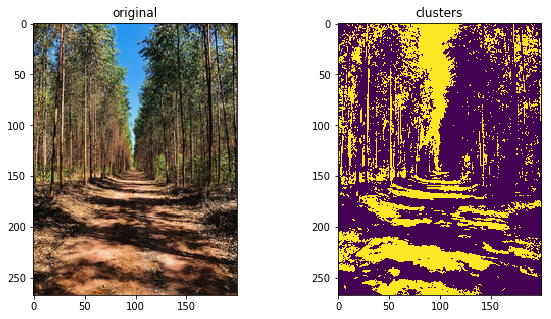

In [98]:
# function to run the k-means routine in 'n' iterations
def kmeans_routine(dataset, centroids, k, n):
    r=centroids.shape[1]
    # create the frame for labeling the image
    label_img = np.zeros((dataset.shape[0],dataset.shape[1]), dtype=np.uint8)

    # loop to repeat 'n' times the iteration
    for iteration in range(n):
        # loops to run all dataset, labeling the objects according to centroids similarity
        for x in range(dataset.shape[0]):
            for y in range(dataset.shape[1]):
                if(np.sum(dataset[x,y]) == 0):
                    label_img[x,y] = 1
                else:
                    # collect an example object from dataset to be labeled
                    example = dataset[x,y]

                    # according to similarity, select the cluster in which the example belongs
                    cluster = closest_cluster(centroids, example)
                    # set the label_img pixel value to cluster's number
                    label_img[x,y] = cluster

        # update the centroids by calculating the average of attributes of each formed clusters
        centroids = update_centroids(label_img, dataset, centroids)
#         print(centroids)
#         plt.figure(figsize=(5,5))
#         plt.imshow(label_img); plt.title("iteration "+ str(iteration+1))
        
    return label_img

result = kmeans_routine(luminance_dataset, luminance_centroids, 2, 1)

plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(img); plt.title("original")
plt.subplot(122); plt.imshow(result); plt.title("clusters")

In [103]:
def label_frame(frame, dataset, clusters):
    for i in range(1,np.max(clusters)+1):
        cluster = dataset[np.where(clusters == i)]
        coordinates = (cluster[:,-2],cluster[:,-1])
        frame[coordinates] = i
    
    return(frame)

In [17]:
# readjustment of range of values
def range_adjustment(img,minvalue=0,maxvalue=255):
    try:
        layers = img.shape[2]
    except:
        layers = 1
    
    img_u8 = np.zeros(img.shape, dtype=np.uint8)
    if(layers > 1):
        for z in range(layers):
            currmin = np.min(img[:,:,z])
            currmax = np.max(img[:,:,z])
            for x in range(img.shape[0]):
                for y in range(img.shape[1]):
                    img_u8[x,y,z] = ((img[x,y,z]-currmin)*(maxvalue - minvalue)//(currmax - currmin)) + minvalue
    else:
        currmin = np.min(img)
        currmax = np.max(img)
        for x in range(img.shape[0]):
            for y in range(img.shape[1]):
                img_u8[x,y] = ((img[x,y]-currmin)*(maxvalue - minvalue)//(currmax - currmin)) + minvalue
    
    return img_u8 

In [112]:
nonshadow_mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)

idx, idy = np.where(result==2)
coordinates = np.append(np.transpose([idx]),np.transpose([idy]),axis=1)
nonshadow_dataset = np.dstack(([img[np.where(result == 2)]],
                           [coordinates]))


nonshadow_centroids=np.array([[np.max(nonshadow_dataset[:,:,0]),0,0,img.shape[0]-1,img.shape[1]//2],
                         [0,np.max(nonshadow_dataset[:,:,1]),0,img.shape[0]//2,0],
                         [0,np.max(nonshadow_dataset[:,:,1]),0,img.shape[0]//2,img.shape[1]-1],
                         [0,0,np.max(nonshadow_dataset[:,:,2]),0,img.shape[1]//2]])

nonshadow_clusters = kmeans_routine(nonshadow_dataset, nonshadow_centroids, 4, 3)

nonshadow_mask = label_frame(nonshadow_mask, nonshadow_dataset, nonshadow_clusters)


Text(0.5, 1.0, 'nonshadow clusters')

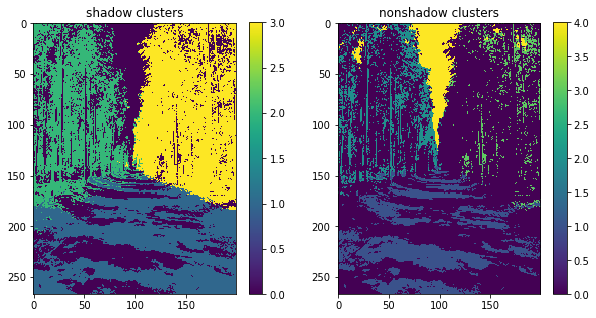

In [118]:
shadow_mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)

idx, idy = np.where(result==1)
coordinates = np.append(np.transpose([idx]),np.transpose([idy]),axis=1)
shadow_dataset = np.dstack(([img[np.where(result == 1)]],
                           [coordinates]))

shadow_centroids=np.array([[np.max(shadow_dataset[:,:,0]),0,0,img.shape[0]-1,img.shape[1]//2],
                         [0,np.max(shadow_dataset[:,:,1]),0,img.shape[0]//2,0],
                         [0,np.max(shadow_dataset[:,:,1]),0,img.shape[0]//2,img.shape[1]-1]])

shadow_clusters = kmeans_routine(shadow_dataset, shadow_centroids, 3, 3)

shadow_mask = label_frame(shadow_mask, shadow_dataset, shadow_clusters)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(shadow_mask)
plt.colorbar()
plt.title("shadow clusters")
plt.subplot(122)
plt.imshow(nonshadow_mask)
plt.colorbar()
plt.title("nonshadow clusters")

In [ ]:

plt.figure(figsize=(10,10))
plt.subplot(221); plt.imshow(shadow_dataset); plt.title("shadowed regions")
plt.subplot(222); plt.imshow(nonshadow_dataset); plt.title("nonshadowed regions")
plt.subplot(223); plt.imshow(shadow_clusters); plt.title("shadowed clusters")
plt.subplot(224); plt.imshow(nonshadow_clusters); plt.title("nonshadowed clusters")